## Exploratory Data Analysis

This notebook contains all the initial analysis done on the data.

The code in this notebook corresponds to the __Primary Analysis__ section of the report.

## Packages
Importing all necessary packages to run the notebook

In [73]:
# data handling and manipulation
from pathlib import Path
import pandas as pd
import datetime

# statistics
import scipy.stats as stats

# data visualisation
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

## Directory navigation and creation
Creating pathlib.Path objects for cross-platform navigation and loading the three datasets into pandas DataFrame objects

**Note:** here we import the cleaned accidents.pkl file

In [74]:
# creating Path object for current working directory
cwd = Path('./')
root_dir = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root_dir / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directory
plots_dir = root_dir / 'plots'
# create new directory for plots directory
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = Path(root_dir / 'data')

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/accidents2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/casualties2019.csv
/Volumes/GoogleDrive/My Drive/Dev/TrafficAccidents/data/vehicles2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010128300,-0.153842,51.508057,1,3,2,3,2,1,E09000033,...,E01004762,westminster,2019-02-18,17:50:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 17:50:00,17.833333,49
1,2019010164251,-0.141154,51.502191,1,3,1,2,2,1,E09000033,...,E01004736,westminster,2019-02-18,18:50:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 18:50:00,18.833333,49
2,2019010164259,-0.174097,51.527663,1,3,2,1,2,1,E09000033,...,E01004728,westminster,2019-02-18,23:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 23:00:00,23.000000,49
3,2019010164414,-0.163973,51.515931,1,3,2,1,2,1,E09000033,...,E01004658,westminster,2019-02-18,02:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 02:00:00,2.000000,49
4,2019010164107,-0.103521,51.464277,1,3,1,1,2,9,E09000022,...,E01003051,lambeth,2019-02-18,08:00:00,0 days 07:10:00,0 days 17:19:00,10:09:00,2019-02-18 08:00:00,8.000000,49


## Accidents by time of day

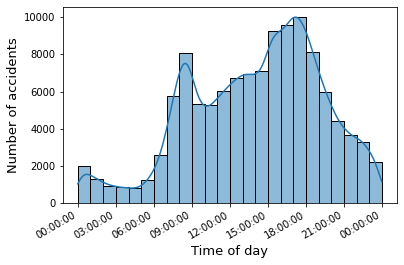

In [75]:
# plot the frequency of accidents by time of day
time_of_day = sns.histplot(data=accidents,
             x='decimal_time',
             binwidth=1,
             kde=True,
             stat='count')

# set the axis labels
time_of_day.set_xlabel("Time of day", fontsize=13)
time_of_day.set_ylabel("Number of accidents", fontsize=13)

# set the x ticks
x_ticks = list(range(0, 25, 3))
x_labels = [datetime.time(x % 24).isoformat() for x in x_ticks]
time_of_day.xaxis.set_ticks(x_ticks, x_labels)
time_of_day.figure.autofmt_xdate()

# convert AxesSubplot to a Figure object and save to the plot directory
tod_fig = time_of_day.get_figure()
tod_fig.savefig(plots_dir / 'time_of_day', bbox_inches='tight')

## Accidents by day of the week

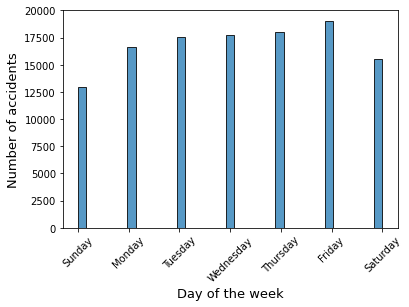

In [76]:
# set variables for xtick labels
xticks = list(range(1, 8))
days = ['Sunday', 'Monday', 'Tuesday',
        'Wednesday', 'Thursday', 'Friday', 'Saturday']

# plot the frequency of accidents by day of the week
by_day = sns.histplot(data=accidents,
             x='day_of_week')
# set axis labels
by_day.set_xlabel("Day of the week", fontsize=13)
by_day.set_ylabel("Number of accidents", fontsize=13)

# set the xtick labels
by_day.set_xticks(xticks, days, rotation=45)

# convert AxesSubplot to a Figure object and save to the plot directory
dow_fig = by_day.get_figure()
dow_fig.savefig(plots_dir / 'day_of_week', bbox_inches='tight')

## Grouping by day of the week and time of day


In [77]:
def group_by_day(df, feature='accident_index', is_categorical=False, function='sum'):
    """
    Groups the dataframe by day_of_week feature
    and does a sum of the column values.
    """
    new_df = df.loc[:, ['day_of_week', feature]]
    if (is_categorical):
        one_hot = pd.get_dummies(new_df.loc[:, feature])
        new_df = pd.concat([new_df, one_hot], axis=1)
    grouped = new_df.groupby('day_of_week')
    if (function == 'sum'):
        return grouped.sum()
    elif (function == 'count'):
        return grouped.count()

def group_by_time(df, freq, feature='accident_index', is_categorical=False, function='sum'):
    """
    Groups the dataframe by converted_time feature
    according to some unit (hours, days etc) and
    does a sum of the column values.
    """
    new_df = df.loc[:, ['converted_time', feature]]
    date = str(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d').date())
    new_df['converted_time'] = pd.to_datetime(date + " " + new_df.converted_time.astype(str))
    if (is_categorical):
        one_hot = pd.get_dummies(new_df.loc[:, feature])
        new_df = pd.concat([new_df, one_hot], axis=1)
    grouped = new_df.groupby(pd.Grouper(key='converted_time', freq=freq))
    if (function == 'sum'):
        return grouped.sum()
    elif (function == 'count'):
        return grouped.count()

In [78]:
# merge the accidents and vehicles datasets
accidents_vehicles = pd.merge(accidents, vehicles, on='accident_index')
accidents_vehicles.columns

Index(['accident_index', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'local_authority_(district)',
       'local_authority_(highway)', '1st_road_class', '1st_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'lsoa_of_accident_location', 'district', 'converted_date',
       'converted_time', 'sunrise', 'sunset', 'day_length', 'datetime',
       'decimal_time', 'day_of_year', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location-restricted_lane',

### Grouping the aggregated accidents by day of the week

In [79]:
# grouping by the day of the week
accidents_by_day = group_by_day(accidents_vehicles, feature='accident_index', function='count')
accidents_by_day['zscore'] = stats.zscore(accidents_by_day['accident_index'])
accidents_by_day.columns = ['accident_count', 'z-score']

accidents_by_day

,accident_count,z-score
day_of_week,,
1,23637,-2.013740
2,30636,-0.076283
3,32525,0.446628
4,32908,0.552649
5,33257,0.649259
6,35244,1.199299
7,28174,-0.757812


## Grouping the accidents by day of the week by vehicle type

In [80]:
vehicle_by_day = group_by_day(accidents_vehicles, 'vehicle_type', True)
vehicle_by_day = vehicle_by_day.drop('vehicle_type', axis=1)

vehicle_type_ref = pd.read_csv(additional_data_dir / 'vehicle_type.csv')
labels = vehicle_type_ref.set_index('code').to_dict()['label']

vehicle_by_day

,-1,1,2,3,4,5,8,9,10,11,...,17,18,19,20,21,22,23,90,97,98
day_of_week,,,,,,,,,,,,,,,,,,,,,
1,32.0,1613.0,177.0,862.0,270.0,841.0,660.0,17628.0,39.0,264.0,...,31.0,4.0,775.0,53.0,115.0,21.0,9.0,113.0,54.0,57.0
2,47.0,2596.0,196.0,1089.0,292.0,636.0,486.0,21381.0,69.0,630.0,...,74.0,5.0,2028.0,150.0,570.0,36.0,9.0,146.0,53.0,137.0
3,54.0,2930.0,232.0,1217.0,311.0,698.0,593.0,22424.0,55.0,600.0,...,70.0,6.0,2129.0,176.0,606.0,45.0,9.0,146.0,57.0,155.0
4,50.0,2945.0,234.0,1256.0,307.0,739.0,664.0,22685.0,65.0,636.0,...,63.0,2.0,2072.0,187.0,597.0,38.0,7.0,148.0,55.0,149.0
5,37.0,2954.0,209.0,1224.0,342.0,758.0,668.0,22835.0,70.0,617.0,...,72.0,3.0,2211.0,167.0,660.0,37.0,9.0,162.0,67.0,148.0
6,49.0,2559.0,265.0,1400.0,339.0,761.0,814.0,24846.0,55.0,656.0,...,67.0,2.0,2199.0,187.0,609.0,36.0,10.0,162.0,63.0,162.0
7,40.0,1840.0,176.0,1005.0,258.0,795.0,811.0,20887.0,52.0,499.0,...,46.0,4.0,1165.0,62.0,200.0,37.0,12.0,128.0,66.0,82.0


### Create a dictionary of form { vehicle_type: df(accident_stats) }

In [81]:
by_vehicle_day = {}

def type_by_day(vehicles_by_day, accidents_by_day):
    """
    Creates a dictionary of the form { vehicle_type: df(accident_stats) }
    for all vehicle_types present in the dataset aggregated on day of the week.
    """
    for col in vehicles_by_day.columns:
        vehicle_df = pd.DataFrame(vehicles_by_day.loc[:, col])
        vehicle_df['z-score'] = stats.zscore(vehicle_df)
        vehicle_df.columns = ['accident_count', 'z-score']
        vehicle_df['ratio'] = vehicle_df.accident_count / accidents_by_day.accident_count
        vehicle_df['day_of_week'] = vehicle_df.index
        by_vehicle_day[col] = vehicle_df
        
type_by_day(vehicle_by_day, accidents_by_day)

print(by_vehicle_day.keys())
by_vehicle_day[9] # index 9 == Car

dict_keys([-1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98])


,accident_count,z-score,ratio,day_of_week
day_of_week,,,,
1,17628.0,-2.023375,0.745780,1
2,21381.0,-0.208555,0.697904,2
3,22424.0,0.295804,0.689439,3
4,22685.0,0.422014,0.689346,4
5,22835.0,0.494549,0.686622,5
6,24846.0,1.466999,0.704971,6
7,20887.0,-0.447436,0.741357,7


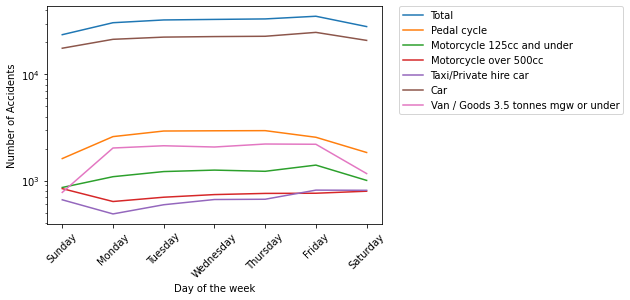

In [82]:
# plotting accidents by day of the week by vehicle type
sns.lineplot(data=accidents_by_day, x='day_of_week', y='accident_count', label='Total')
for vehicle, data in by_vehicle_day.items():
    if data.ratio.mean() > 0.02:
        vehicle_day_plot = sns.lineplot(data=data, x='day_of_week', y='accident_count', label=labels[vehicle])
vehicle_day_plot.set_yscale('log')
vehicle_day_plot.set_xlabel("Day of the week")
vehicle_day_plot.set_ylabel("Number of Accidents")
vehicle_day_plot.set_xticks(range(1, 8), ['Sunday', 'Monday', 'Tuesday',
                                          'Wednesday', 'Thursday', 'Friday',
                                          'Saturday'],
                           rotation=45)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

vehicle_day_plot.figure.savefig(plots_dir / 'vehicle_day_plot', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Total accidents by hour of the day


In [83]:
# grouping by time of day
accidents_by_hour = group_by_time(accidents_vehicles, freq='H', function='count')
accidents_by_hour['zscore'] = stats.zscore(accidents_by_hour['accident_index'])
accidents_by_hour.columns = ['accident_count', 'z-score']
accidents_by_hour

,accident_count,z-score
converted_time,,
2018-01-01 00:00:00,3121,-1.063004
2018-01-01 01:00:00,2187,-1.231429
2018-01-01 02:00:00,1597,-1.337822
2018-01-01 03:00:00,1293,-1.392641
2018-01-01 04:00:00,1307,-1.390116
2018-01-01 05:00:00,2072,-1.252166
2018-01-01 06:00:00,4466,-0.820464
2018-01-01 07:00:00,10312,0.233726
2018-01-01 08:00:00,15028,1.084147


## Grouping the accidents by hour of the day by vehicle

In [84]:
vehicle_by_hour= group_by_time(accidents_vehicles, 'H', 'vehicle_type', True)
vehicle_by_hour = vehicle_by_hour.drop('vehicle_type', axis=1)

vehicle_by_hour

,-1,1,2,3,4,5,8,9,10,11,...,17,18,19,20,21,22,23,90,97,98
converted_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,4.0,119.0,21.0,101.0,18.0,31.0,212.0,2357.0,10.0,37.0,...,7.0,0.0,113.0,11.0,41.0,1.0,0.0,15.0,7.0,16.0
2018-01-01 01:00:00,5.0,60.0,9.0,69.0,16.0,19.0,162.0,1666.0,6.0,22.0,...,1.0,0.0,92.0,10.0,33.0,0.0,1.0,7.0,4.0,5.0
2018-01-01 02:00:00,1.0,38.0,9.0,48.0,10.0,13.0,130.0,1224.0,2.0,16.0,...,0.0,0.0,57.0,5.0,28.0,0.0,0.0,9.0,1.0,6.0
2018-01-01 03:00:00,2.0,34.0,2.0,29.0,3.0,8.0,123.0,961.0,2.0,14.0,...,2.0,0.0,47.0,7.0,40.0,0.0,0.0,9.0,2.0,8.0
2018-01-01 04:00:00,1.0,43.0,9.0,35.0,4.0,10.0,78.0,977.0,2.0,14.0,...,1.0,0.0,71.0,5.0,38.0,1.0,0.0,9.0,0.0,9.0
2018-01-01 05:00:00,2.0,179.0,13.0,62.0,17.0,34.0,84.0,1370.0,4.0,23.0,...,4.0,0.0,158.0,12.0,81.0,1.0,0.0,8.0,3.0,17.0
2018-01-01 06:00:00,5.0,457.0,22.0,144.0,43.0,115.0,93.0,2917.0,5.0,49.0,...,3.0,0.0,376.0,40.0,131.0,3.0,2.0,24.0,7.0,30.0
2018-01-01 07:00:00,9.0,1209.0,49.0,380.0,100.0,288.0,142.0,6685.0,16.0,135.0,...,21.0,1.0,882.0,61.0,220.0,2.0,4.0,49.0,10.0,48.0
2018-01-01 08:00:00,25.0,1752.0,81.0,434.0,137.0,330.0,231.0,10171.0,38.0,228.0,...,25.0,1.0,1057.0,78.0,278.0,11.0,6.0,55.0,16.0,72.0


### Create a dictionary of form { vehicle_type: df(accident_stats) }

In [85]:
by_vehicle_hour = {}

def type_by_hour(vehicles_by_hour, accidents_by_hour):
    """
    Creates a dictionary of the form { vehicle_type: df(accident_stats) }
    for all vehicle_types present in the dataset aggregated on the hour of the day.
    """
    for col in vehicles_by_hour.columns:
        vehicle_df = pd.DataFrame(vehicles_by_hour.loc[:, col])
        vehicle_df['z-score'] = stats.zscore(vehicle_df)
        vehicle_df.columns = ['accident_count', 'z-score']
        vehicle_df['ratio'] = vehicle_df.accident_count / accidents_by_hour.accident_count
        by_vehicle_hour[col] = vehicle_df
        
type_by_hour(vehicle_by_hour, accidents_by_hour)

by_vehicle_hour[9] # 9 == Car

,accident_count,z-score,ratio
converted_time,,,
2018-01-01 00:00:00,2357.0,-1.032167,0.755207
2018-01-01 01:00:00,1666.0,-1.210255,0.761774
2018-01-01 02:00:00,1224.0,-1.324169,0.766437
2018-01-01 03:00:00,961.0,-1.391951,0.743233
2018-01-01 04:00:00,977.0,-1.387828,0.747513
2018-01-01 05:00:00,1370.0,-1.286542,0.661197
2018-01-01 06:00:00,2917.0,-0.887841,0.653157
2018-01-01 07:00:00,6685.0,0.083267,0.648274
2018-01-01 08:00:00,10171.0,0.981696,0.676803


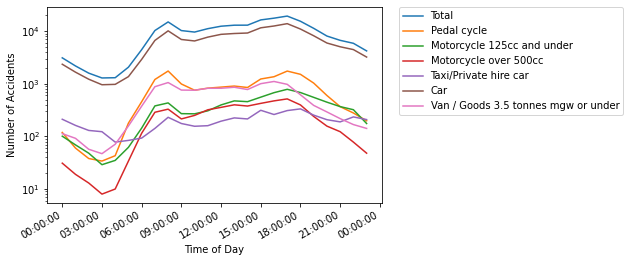

In [86]:
vehicle_hour_plot = sns.lineplot(data=accidents_by_hour, x='converted_time', y='accident_count', label='Total')
for vehicle, data in by_vehicle_hour.items():
    if data.ratio.mean() > 0.02:
        vehicle_hour_plot = sns.lineplot(data=data, x='converted_time', y='accident_count', label=labels[vehicle])
vehicle_hour_plot.set_yscale('log')
vehicle_hour_plot.set_xlabel("Time of Day")
vehicle_hour_plot.set_ylabel("Number of Accidents")

hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%H:%M:%S')


vehicle_hour_plot.xaxis.set_major_locator(hours)
vehicle_hour_plot.xaxis.set_major_formatter(h_fmt)

vehicle_hour_plot.figure.autofmt_xdate()

lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

vehicle_hour_plot.figure.savefig(plots_dir / 'vehicle_hour_plot', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Preliminary hypothesis tests

### Does the first point of impact affect accident severity?

In [94]:
impact = pd.merge(vehicles.filter(['accident_index', '1st_point_of_impact']), accidents.filter(['accident_index', 'accident_severity']), on='accident_index')
impact = impact[impact['1st_point_of_impact'] >= 0]
impact = impact.drop('accident_index', axis=1)

impact.head(5)

,1st_point_of_impact,accident_severity
0,4,3
2,1,3
4,2,3
5,1,3
6,0,2


In [95]:
data = impact.to_numpy().T

# cramer V for point of impact and accident severity
stats.contingency.association(data, method='cramer')

0.31389133037152844

### Does the casualty type affect accident severity?

In [96]:
casualty_types = pd.merge(casualties.filter(['accident_index', 'casualty_type']), accidents.filter(['accident_index', 'accident_severity']), on='accident_index')
casualty_types = casualty_types[casualty_types['casualty_type'] >= 0]
casualty_types = casualty_types.drop('accident_index', axis=1)

casualty_types

,casualty_type,accident_severity
0,9,3
1,9,3
2,9,3
3,9,3
4,1,3
...,...,...
153153,19,3
153154,19,3
153155,9,3
153156,0,3


In [97]:
data = casualty_types.to_numpy().T

# cramer V for casualty type and accident severity
stats.contingency.association(data, method='cramer')

0.4345987398609373